In [17]:
import os
import pandas as pd

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define your folder path (edit this to match your Drive structure)
folder_path = '/content/drive/MyDrive/ivan_dados_artigo_revisão/brazil_2025_2020'  # Change as needed

# Step 3: List all .xls and .csv files in the folder
files = [f for f in os.listdir(folder_path) if f.endswith('.xls') or f.endswith('.csv')]

dataframes = []

for file in files:
    file_path = os.path.join(folder_path, file)
    print(f"Reading: {file}")
    if file.endswith('.xls'):
        df = pd.read_excel(file_path, engine='xlrd')
    else:
        try:
            df = pd.read_csv(file_path, encoding='utf-8', sep=',', low_memory=False)
        except Exception:
            df = pd.read_csv(file_path, encoding='utf-8', sep=';', low_memory=False)
    dataframes.append(df)

# Step 4: Concatenate all DataFrames into a single one
merged_df = pd.concat(dataframes, ignore_index=True)

# Step 5: Remove duplicates (optional)
merged_df = merged_df.drop_duplicates()

print(f'Total records after merging: {merged_df.shape[0]}')
merged_df.info()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading: savedrecs.xls
Total records after merging: 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 79 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Publication Type                    24 non-null     object 
 1   Authors                             20 non-null     object 
 2   Book Authors                        0 non-null      float64
 3   Group Authors                       0 non-null      float64
 4   Book Group Authors                  0 non-null      float64
 5   Researcher Ids                      13 non-null     object 
 6   ORCIDs                              16 non-null     object 
 7   Book Editors                        0 non-null      float64
 8   Author - Arabic                     0 non-null      float6

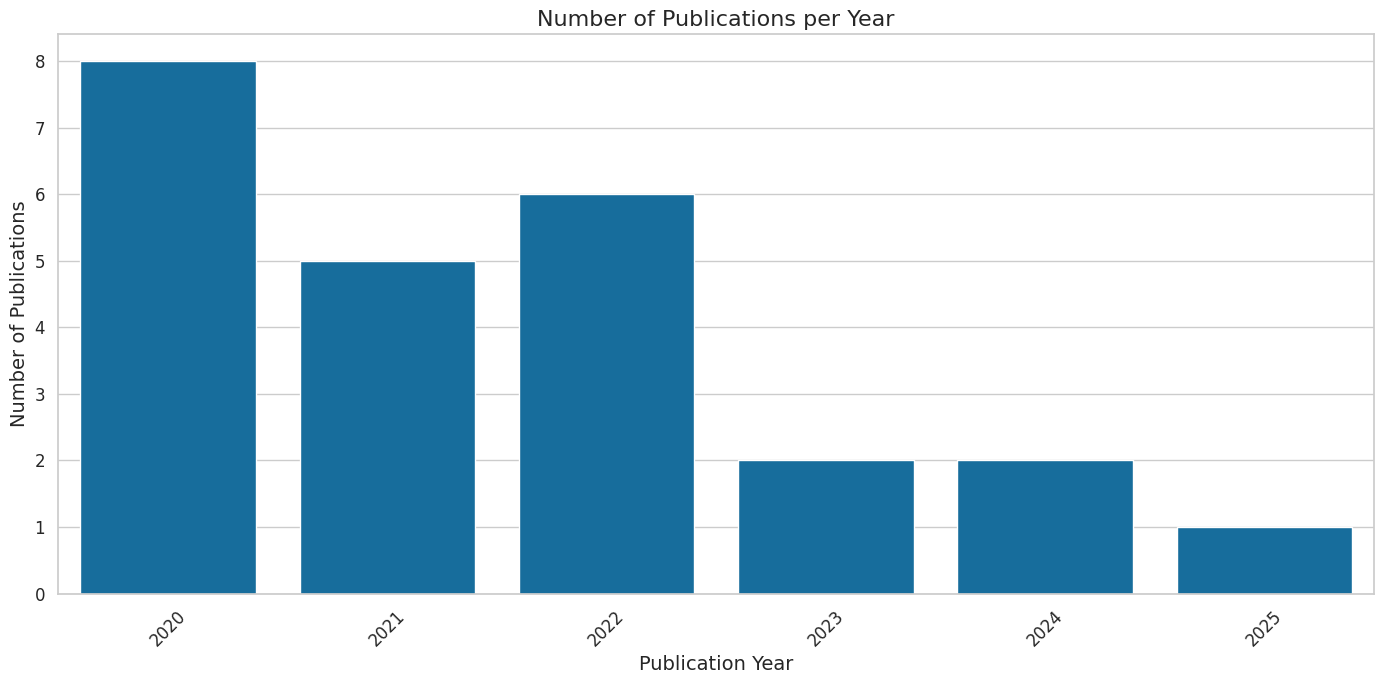

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Output directory (current notebook folder)
output_dir = folder_path
sns.set_theme(style="whitegrid", palette="colorblind")

# Clean and restrict to a reasonable year range
merged_df['Publication Year'] = merged_df['Publication Year'].astype(str).str.extract(r'(\d{4})')[0]
merged_df = merged_df.dropna(subset=['Publication Year'])
merged_df['Publication Year'] = merged_df['Publication Year'].astype(int)
# Optionally restrict to 2000–2025 or another relevant interval
filtered_df = merged_df[(merged_df['Publication Year'] >= 2000) & (merged_df['Publication Year'] <= 2025)]

publications_per_year = filtered_df['Publication Year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid", palette="colorblind")
ax = sns.barplot(x=publications_per_year.index, y=publications_per_year.values)

ax.set_xlabel('Publication Year', fontsize=14)
ax.set_ylabel('Number of Publications', fontsize=14)
ax.set_title('Number of Publications per Year', fontsize=16)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_per_year.png"), dpi=300)
plt.show()



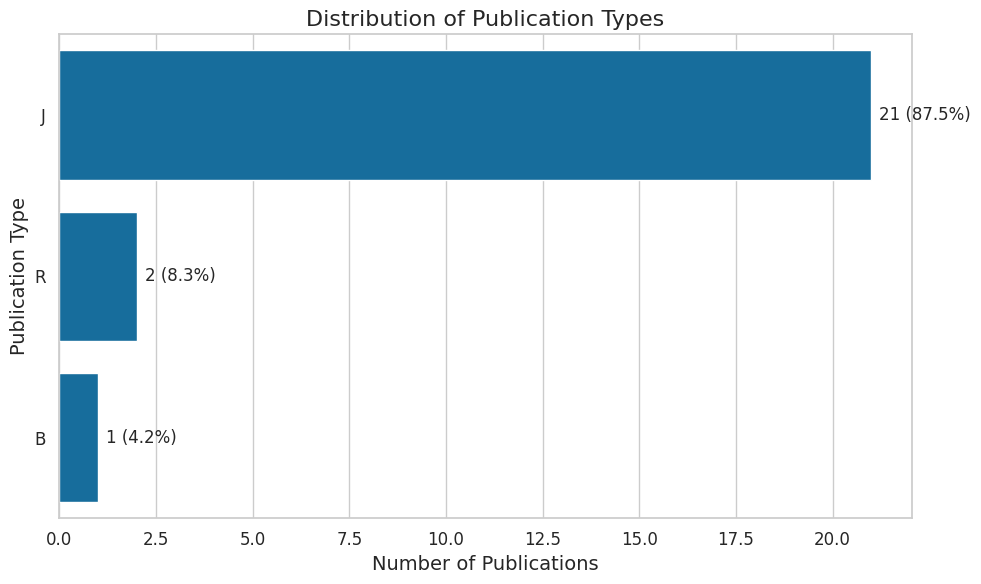

In [19]:
# 2. Distribution of Publication Types
type_counts = merged_df['Publication Type'].astype(str).str.strip().value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=type_counts.index, x=type_counts.values, orient='h')
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Publication Type', fontsize=14)
ax.set_title('Distribution of Publication Types', fontsize=16)
for i, v in enumerate(type_counts.values):
    ax.text(v + max(type_counts.values)*0.01, i, f"{v} ({v/type_counts.sum()*100:.1f}%)", va='center', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publication_type_distribution.png"), dpi=300)
plt.show()



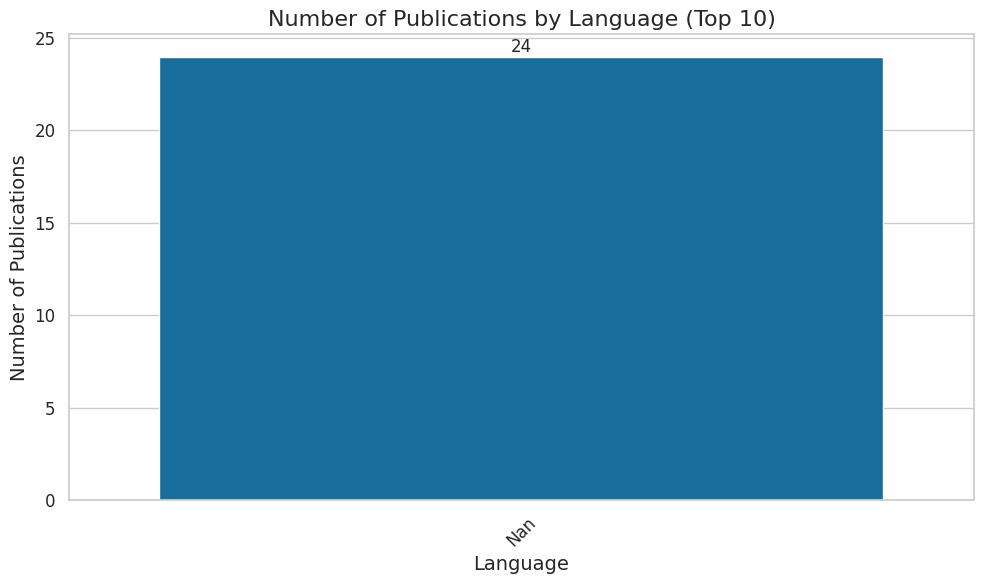

In [20]:
# 3. Number of Publications by Language (top 10)
merged_df['Language'] = merged_df['Language'].astype(str).str.strip().str.title()
lang_counts = merged_df['Language'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=lang_counts.index, y=lang_counts.values)
ax.set_xlabel('Language', fontsize=14)
ax.set_ylabel('Number of Publications', fontsize=14)
ax.set_title('Number of Publications by Language (Top 10)', fontsize=16)
for i, v in enumerate(lang_counts.values):
    ax.text(i, v + max(lang_counts.values)*0.01, f"{v}", ha='center', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_language.png"), dpi=300)
plt.show()



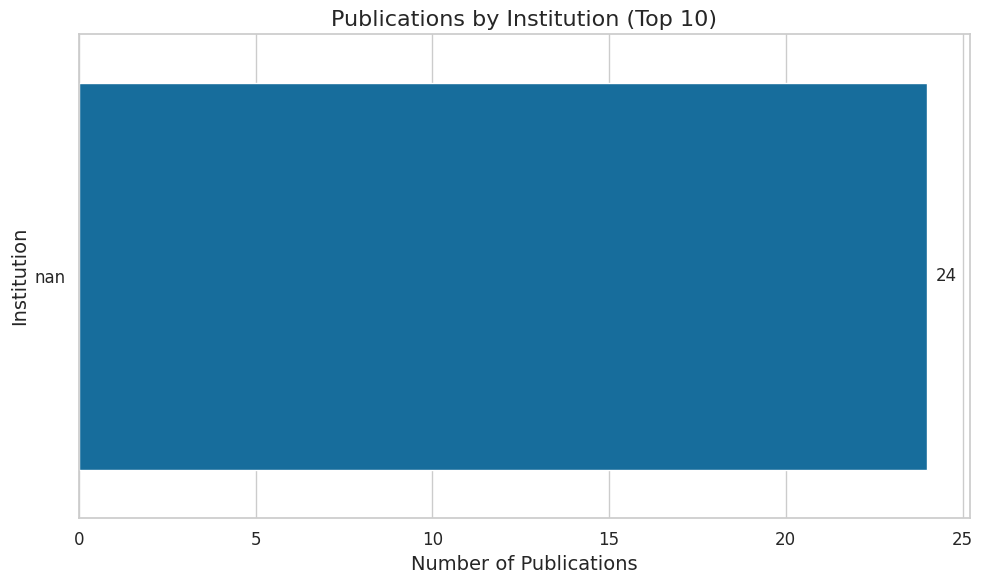

In [21]:
# 4. Publications by Institution (Top 10)
institution_col = 'Institution' if 'Institution' in merged_df.columns else 'Institution Address'
merged_df[institution_col] = merged_df[institution_col].astype(str).str.strip()
inst_counts = merged_df[institution_col].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=inst_counts.index, x=inst_counts.values, orient='h')
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Institution', fontsize=14)
ax.set_title('Publications by Institution (Top 10)', fontsize=16)
for i, v in enumerate(inst_counts.values):
    ax.text(v + max(inst_counts.values)*0.01, i, f"{v}", va='center', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_institution.png"), dpi=300)
plt.show()



/tmp/ipython-input-22-3300391629.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=list(authors), x=list(counts), palette=colors)


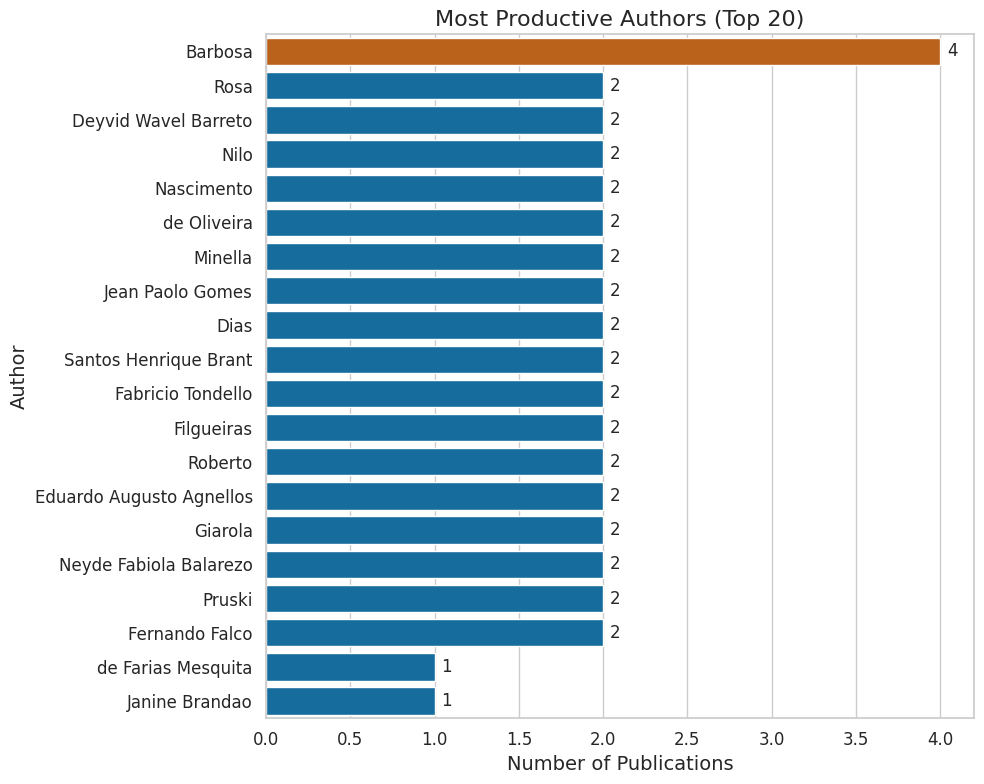

In [22]:
# 5. Most Productive Authors (Top 20)
from collections import Counter
# Split authors by semicolon or comma, strip spaces
author_series = merged_df['Authors'].dropna().apply(lambda x: [a.strip() for a in str(x).replace(';', ',').split(',')])
author_flat_list = [author for sublist in author_series for author in sublist if author]
author_counts = Counter(author_flat_list)
top_authors = author_counts.most_common(20)
authors, counts = zip(*top_authors)

plt.figure(figsize=(10, 8))
colors = ['#0072B2' if count <= np.mean(counts) else '#D55E00' for count in counts]
ax = sns.barplot(y=list(authors), x=list(counts), palette=colors)
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Author', fontsize=14)
ax.set_title('Most Productive Authors (Top 20)', fontsize=16)
for i, v in enumerate(counts):
    ax.text(v + max(counts)*0.01, i, f"{v}", va='center', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "most_productive_authors.png"), dpi=300)
plt.show()


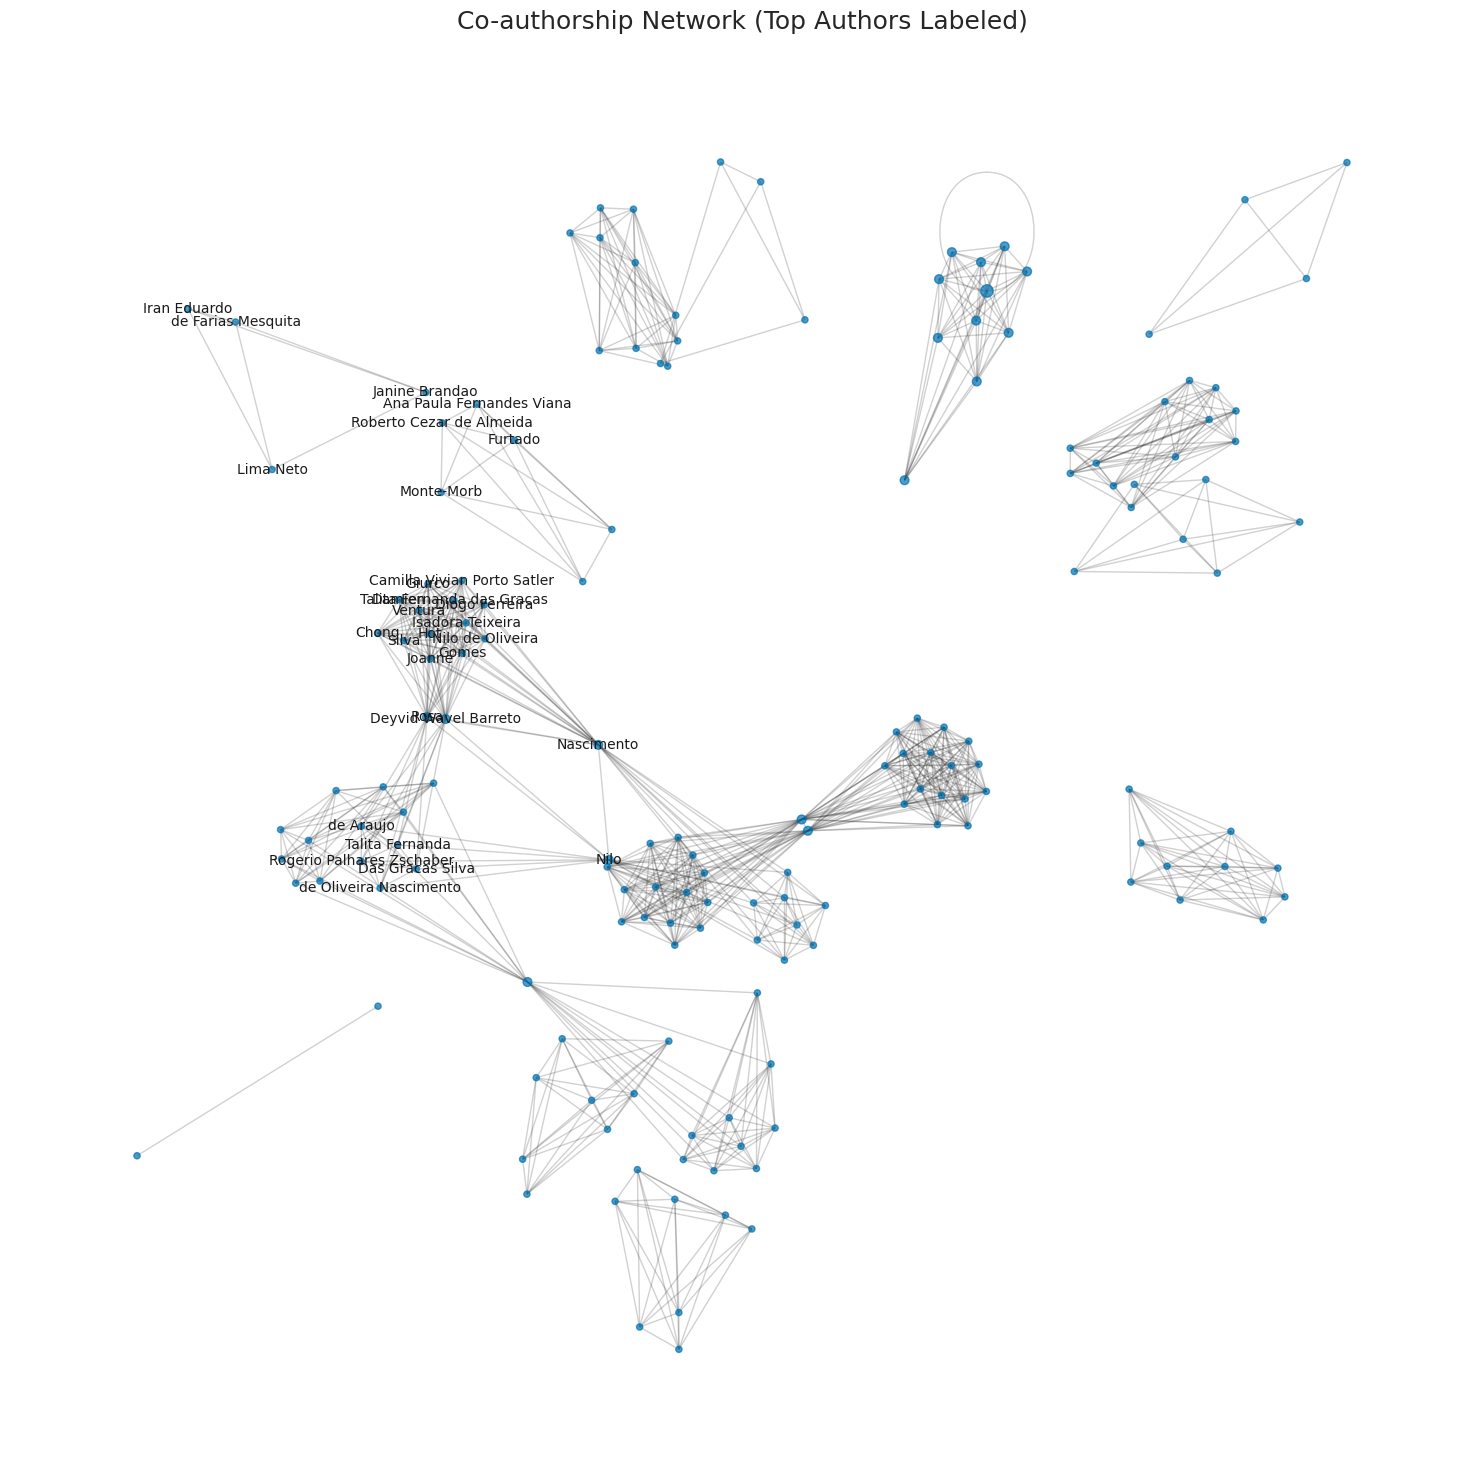

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Prepare list of all author pairs in each paper
author_series = merged_df['Authors'].dropna().apply(lambda x: [a.strip() for a in str(x).replace(';', ',').split(',') if a.strip()])
edges = []
for authors in author_series:
    if len(authors) > 1:
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                edges.append((authors[i], authors[j]))

# Build the co-authorship network
G = nx.Graph()
G.add_edges_from(edges)

# Node size proportional to publication count
author_counts = author_series.explode().value_counts()
node_sizes = [author_counts.get(node, 1)*20 for node in G.nodes()]

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#0072B2', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, {node: node for node in list(G.nodes)[:30]}, font_size=10)  # Label only the 30 largest for clarity

plt.title('Co-authorship Network (Top Authors Labeled)', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "coauthorship_network.png"), dpi=300)
plt.show()


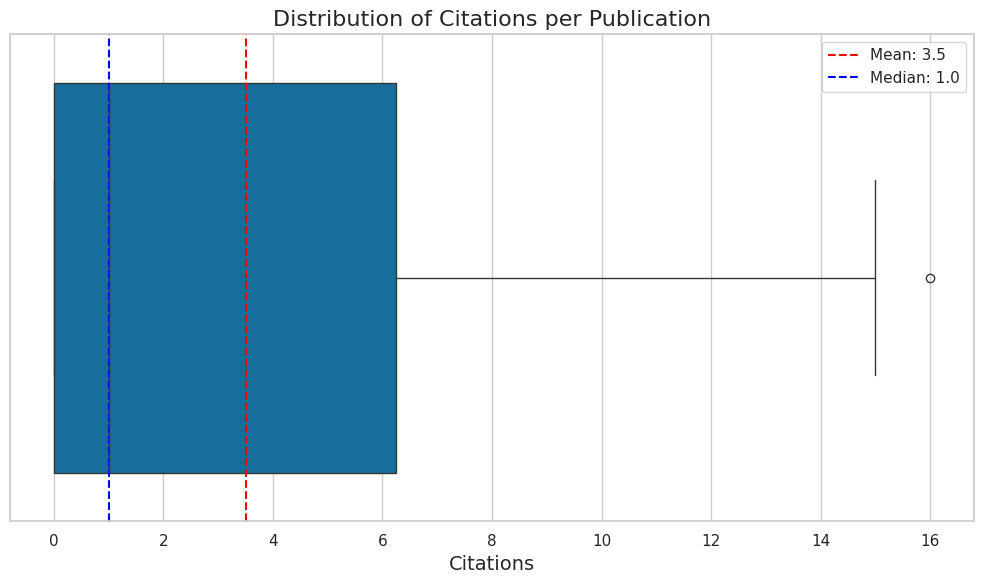

In [24]:
import seaborn as sns
import numpy as np

# Clean and prepare citations data
cit_field = 'Times Cited, All Databases' if 'Times Cited, All Databases' in merged_df.columns else 'Times Cited, WoS Core'
merged_df[cit_field] = pd.to_numeric(merged_df[cit_field], errors='coerce').fillna(0)

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="colorblind")
ax = sns.boxplot(data=merged_df, x=cit_field)
mean_val = merged_df[cit_field].mean()
median_val = merged_df[cit_field].median()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='blue', linestyle='--', label=f'Median: {median_val:.1f}')
ax.set_title('Distribution of Citations per Publication', fontsize=16)
ax.set_xlabel('Citations', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "citations_per_publication_boxplot.png"), dpi=300)
plt.show()

# Optionally, add histogram/violin plot for additional insight


/tmp/ipython-input-25-939266720.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=source_plot.index, x=source_plot.values, palette="colorblind")


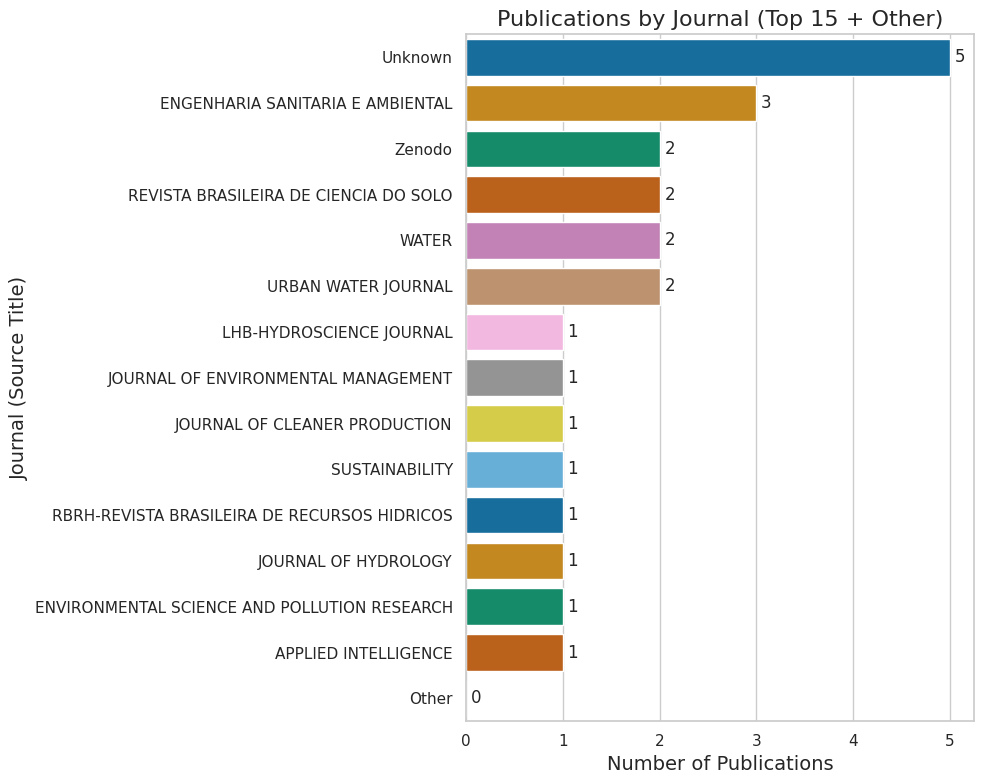

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

top_n = 15
source_counts = merged_df['Source Title'].fillna('Unknown').astype(str).value_counts()
top_sources = source_counts.head(top_n)
others_sum = source_counts[top_n:].sum()
source_plot = pd.concat([top_sources, pd.Series({'Other': others_sum})])

plt.figure(figsize=(10, 8))
ax = sns.barplot(y=source_plot.index, x=source_plot.values, palette="colorblind")
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Journal (Source Title)', fontsize=14)
ax.set_title(f'Publications by Journal (Top {top_n} + Other)', fontsize=16)
for i, v in enumerate(source_plot.values):
    ax.text(v + max(source_plot.values)*0.01, i, f"{v}", va='center', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_journal.png"), dpi=300)
plt.show()


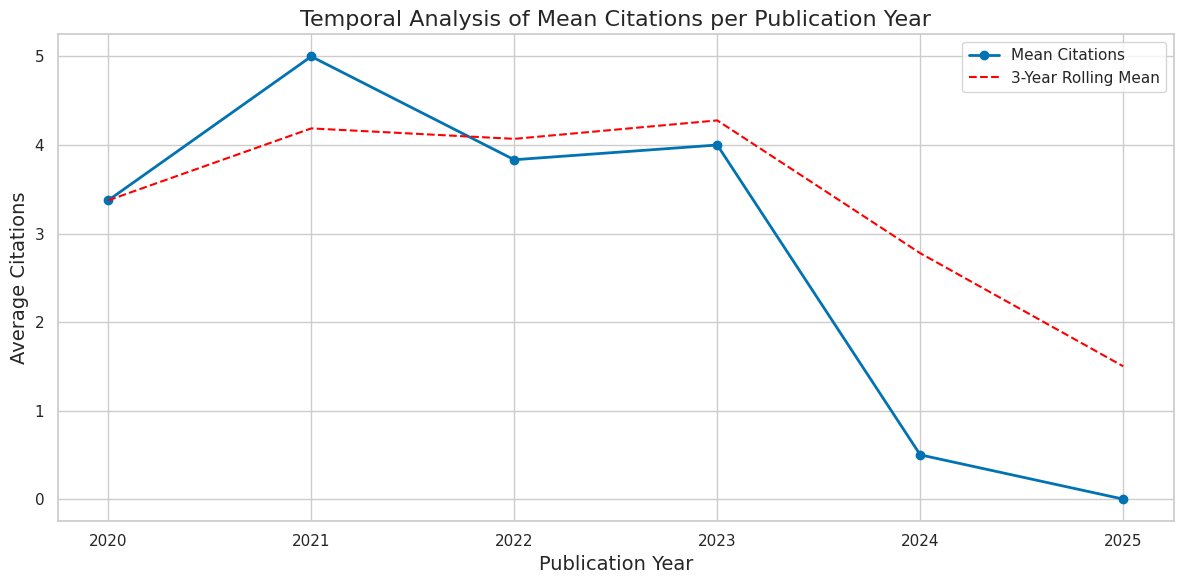

In [26]:
# Prepare and merge data
merged_df['Publication Year'] = merged_df['Publication Year'].astype(str).str.extract(r'(\d{4})')[0]
merged_df = merged_df.dropna(subset=['Publication Year'])
merged_df['Publication Year'] = merged_df['Publication Year'].astype(int)
cit_yearly = merged_df.groupby('Publication Year')[cit_field].mean().sort_index()

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid", palette="colorblind")
plt.plot(cit_yearly.index, cit_yearly.values, marker='o', linewidth=2, label='Mean Citations')
plt.plot(cit_yearly.index, pd.Series(cit_yearly).rolling(3, min_periods=1).mean(), linestyle='--', color='red', label='3-Year Rolling Mean')
plt.xlabel('Publication Year', fontsize=14)
plt.ylabel('Average Citations', fontsize=14)
plt.title('Temporal Analysis of Mean Citations per Publication Year', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "temporal_citations_analysis.png"), dpi=300)
plt.show()


/tmp/ipython-input-27-3075631716.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_cited['Article Title'], x=top_cited[cit_field], palette="colorblind")
/tmp/ipython-input-27-3075631716.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


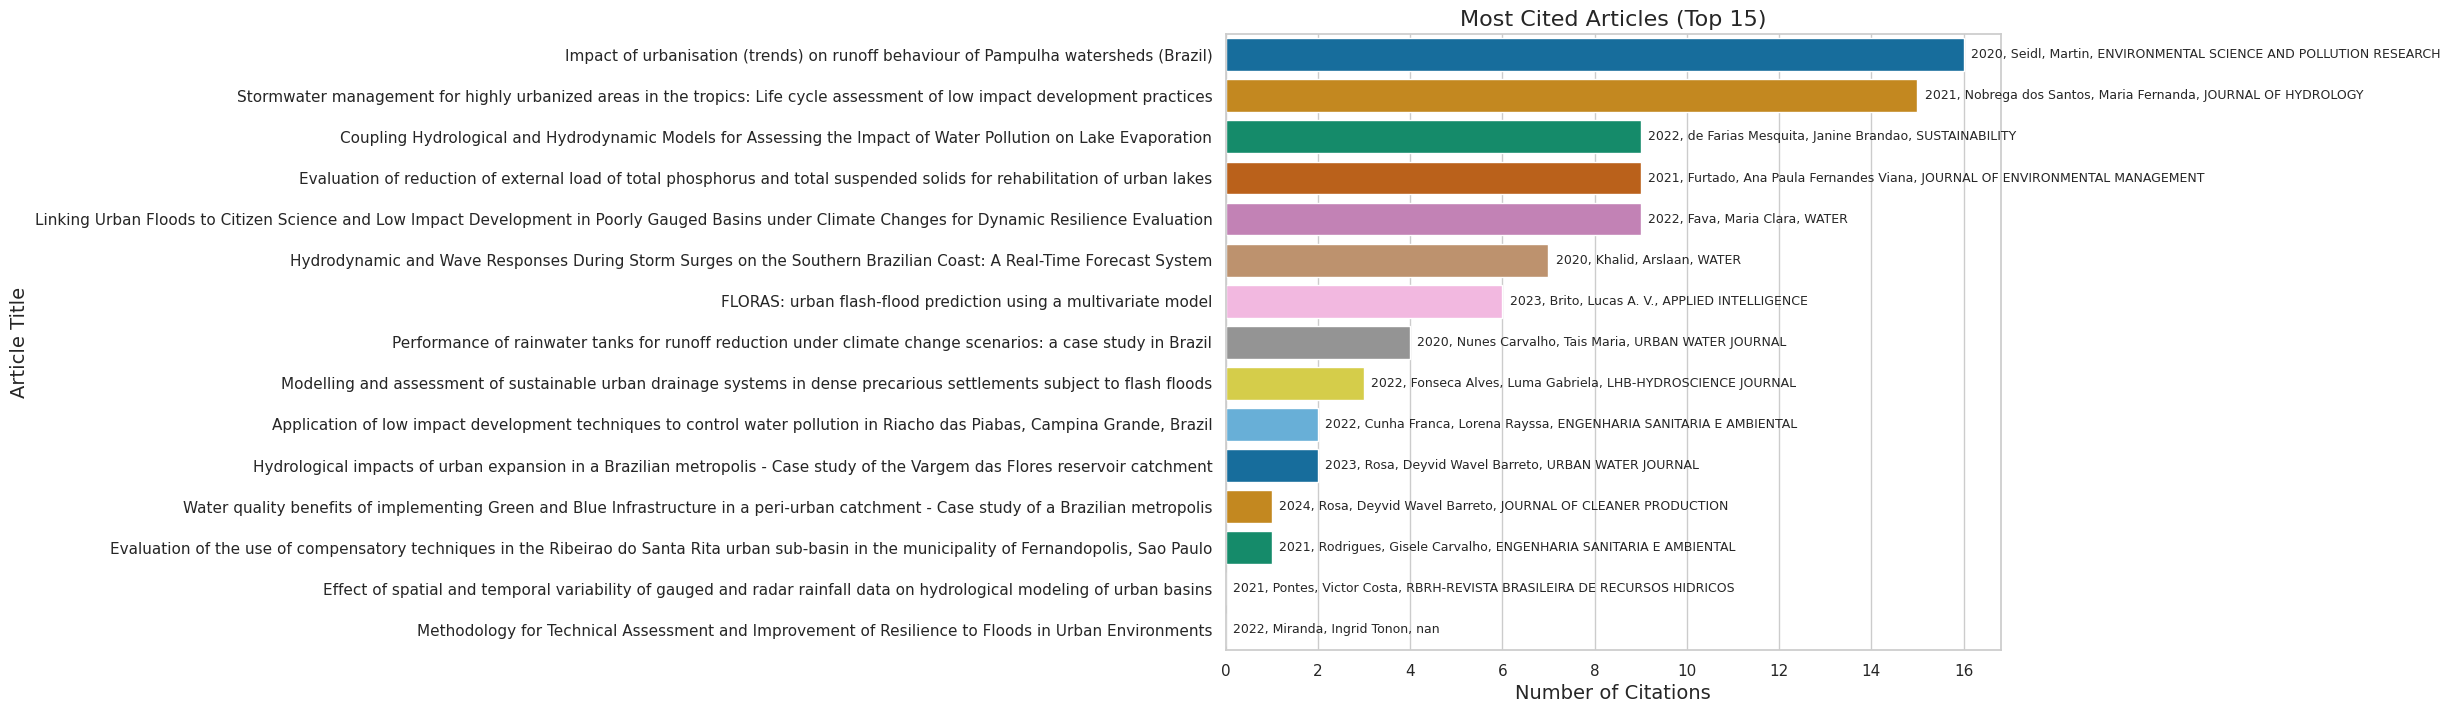

In [27]:
# Prepare data
top_cited = merged_df[['Article Title', cit_field, 'Publication Year', 'Authors', 'Source Title']].dropna(subset=['Article Title'])
top_cited = top_cited.sort_values(by=cit_field, ascending=False).head(15)

plt.figure(figsize=(10, 8))
ax = sns.barplot(y=top_cited['Article Title'], x=top_cited[cit_field], palette="colorblind")
ax.set_xlabel('Number of Citations', fontsize=14)
ax.set_ylabel('Article Title', fontsize=14)
ax.set_title('Most Cited Articles (Top 15)', fontsize=16)
for i, (cit, year, auth, src) in enumerate(zip(top_cited[cit_field], top_cited['Publication Year'], top_cited['Authors'], top_cited['Source Title'])):
    ax.text(cit + max(top_cited[cit_field])*0.01, i, f"{year}, {auth.split(';')[0]}, {src}", va='center', fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "most_cited_articles.png"), dpi=300)
plt.show()


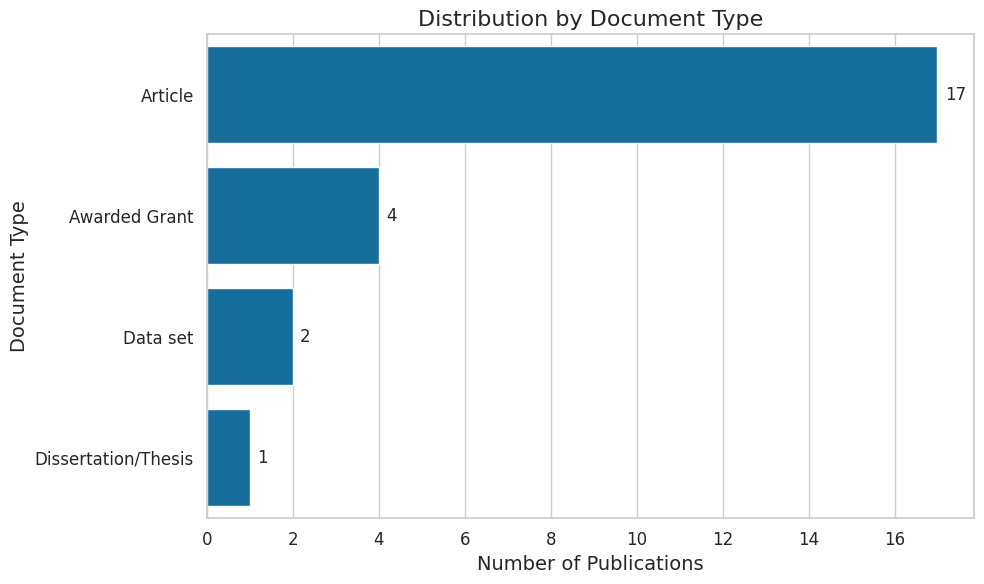

Document Types found: ['Article', 'Awarded Grant', 'Data set', 'Dissertation/Thesis']


In [28]:
# Prepare data
doc_type_counts = merged_df['Document Type'].astype(str).str.strip().value_counts()

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="colorblind")
ax = sns.barplot(y=doc_type_counts.index, x=doc_type_counts.values, orient='h')
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Document Type', fontsize=14)
ax.set_title('Distribution by Document Type', fontsize=16)
for i, v in enumerate(doc_type_counts.values):
    ax.text(v + max(doc_type_counts.values)*0.01, i, f"{v}", va='center', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "distribution_by_document_type.png"), dpi=300)
plt.show()

# Optional: To explain lesser-known categories, you can print:
print("Document Types found:", list(doc_type_counts.index))


In [29]:
!pip install wordcloud


In [30]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

keywords_series = merged_df['Author Keywords'].dropna().astype(str)

if not keywords_series.empty:
    keywords_flat = [kw.strip().lower() for sublist in keywords_series for kw in sublist.replace(';', ',').split(',') if kw.strip()]
    stopwords = set(STOPWORDS).union({'study', 'analysis', 'effect', 'effects', 'data', 'system', 'method', 'methods', 'result', 'results'})
    keywords_cleaned = [kw for kw in keywords_flat if kw not in stopwords]
    top_keywords = Counter(keywords_cleaned).most_common(20)
    if top_keywords:
        words, freqs = zip(*top_keywords)
        # Bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(y=list(words), x=list(freqs), palette="colorblind")
        plt.xlabel('Frequency', fontsize=14)
        plt.ylabel('Keyword', fontsize=14)
        plt.title('Most Frequent Author Keywords (Top 20)', fontsize=16)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "most_frequent_keywords_bar.png"), dpi=300)
        plt.show()
        # Word Cloud
        wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='tab10',
                              stopwords=stopwords, max_words=100).generate(' '.join(keywords_cleaned))
        plt.figure(figsize=(12, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Author Keywords', fontsize=18)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "author_keywords_wordcloud.png"), dpi=300)
        plt.show()
    else:
        print("No valid keywords found after cleaning.")
else:
    print("No author keywords available in the dataset.")


No author keywords available in the dataset.


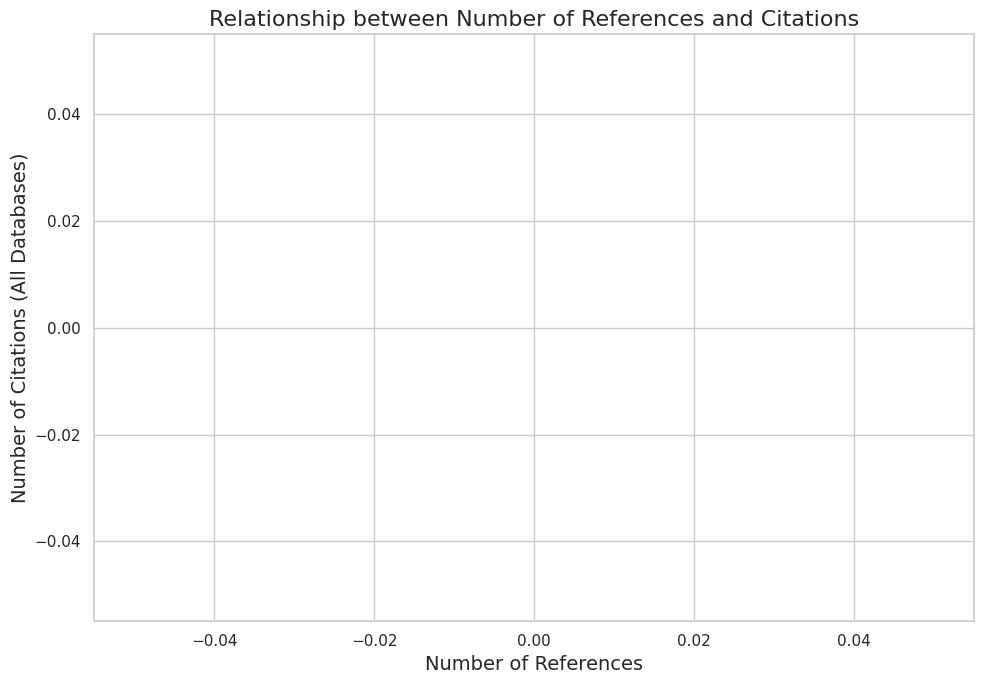

In [31]:
# Clean and prepare data
merged_df['No of References'] = pd.to_numeric(merged_df['No of References'], errors='coerce')
merged_df['Times Cited, All Databases'] = pd.to_numeric(merged_df['Times Cited, All Databases'], errors='coerce')

plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid", palette="colorblind")
ax = sns.scatterplot(data=merged_df, x='No of References', y='Times Cited, All Databases', alpha=0.6)
# Add regression line
sns.regplot(data=merged_df, x='No of References', y='Times Cited, All Databases', scatter=False, color='red', label='Trend Line')
plt.xlabel('Number of References', fontsize=14)
plt.ylabel('Number of Citations (All Databases)', fontsize=14)
plt.title('Relationship between Number of References and Citations', fontsize=16)

# Calculate and show R²
from scipy.stats import linregress
cleaned = merged_df.dropna(subset=['No of References', 'Times Cited, All Databases'])
if not cleaned.empty:
    slope, intercept, r_value, p_value, std_err = linregress(cleaned['No of References'], cleaned['Times Cited, All Databases'])
    plt.text(0.05, 0.95, f'R² = {r_value**2:.3f}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=13, color='red')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "references_vs_citations.png"), dpi=300)
plt.show()


In [32]:
# Prepare data
editors_series = merged_df['Book Editors'].dropna().astype(str)
editors_flat = [ed.strip() for sublist in editors_series for ed in sublist.replace(';', ',').split(',') if ed.strip()]
from collections import Counter
editor_counts = Counter(editors_flat)
top_editors = editor_counts.most_common(15)
editors, counts = zip(*top_editors)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=list(editors), x=list(counts), palette="colorblind")
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Book Editor', fontsize=14)
ax.set_title('Publications by Book Editor (Top 15)', fontsize=16)
for i, v in enumerate(counts):
    ax.text(v + max(counts)*0.01, i, f"{v}", va='center', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_book_editor.png"), dpi=300)
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)

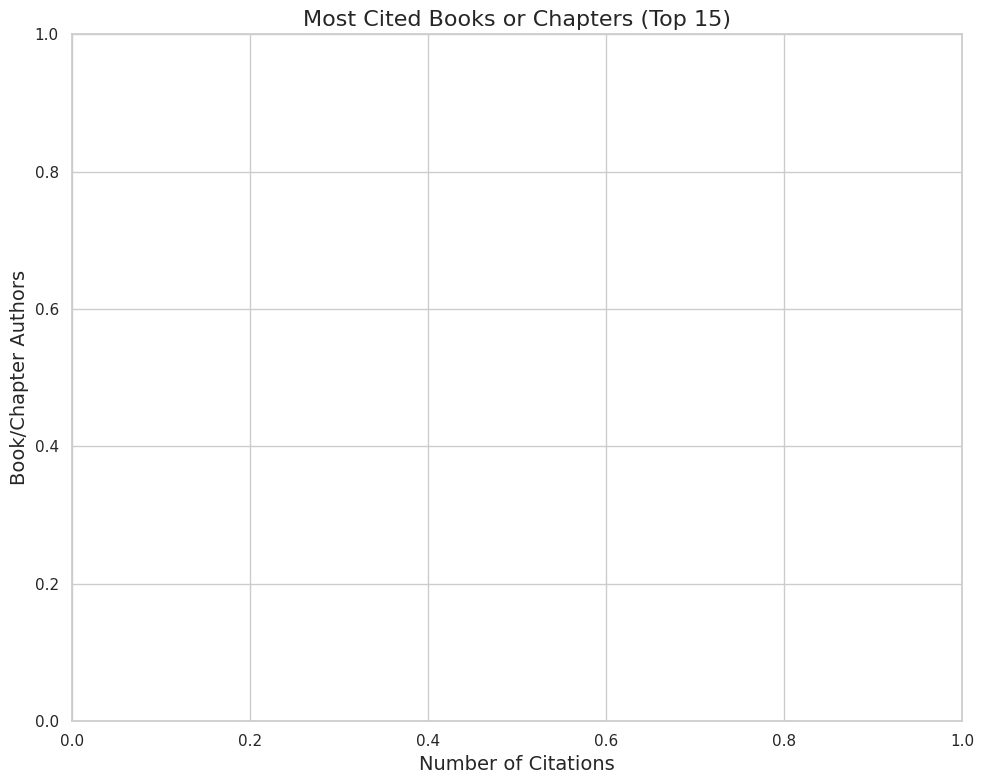

In [33]:
# Prepare data
book_citations = merged_df[['Book Authors', 'Book Editors', 'Times Cited, All Databases', 'Publication Year', 'Institution']].dropna(subset=['Book Authors', 'Times Cited, All Databases'])
book_citations['Times Cited, All Databases'] = pd.to_numeric(book_citations['Times Cited, All Databases'], errors='coerce')
top_books = book_citations.sort_values(by='Times Cited, All Databases', ascending=False).head(15)

plt.figure(figsize=(10, 8))
ax = sns.barplot(y=top_books['Book Authors'], x=top_books['Times Cited, All Databases'], palette="colorblind")
ax.set_xlabel('Number of Citations', fontsize=14)
ax.set_ylabel('Book/Chapter Authors', fontsize=14)
ax.set_title('Most Cited Books or Chapters (Top 15)', fontsize=16)
for i, (cit, year, editor, inst) in enumerate(zip(top_books['Times Cited, All Databases'], top_books['Publication Year'], top_books['Book Editors'], top_books['Institution'])):
    ax.text(cit + max(top_books['Times Cited, All Databases'])*0.01, i, f"{year}, {editor}, {inst}", va='center', fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "most_cited_books_chapters.png"), dpi=300)
plt.show()


In [34]:
# Prepare data
sponsor_series = merged_df['Conference Sponsor'].dropna().astype(str)
sponsors_flat = [s.strip() for sublist in sponsor_series for s in sublist.replace(';', ',').split(',') if s.strip()]
from collections import Counter
sponsor_counts = Counter(sponsors_flat)
top_sponsors = sponsor_counts.most_common(15)
sponsors, counts = zip(*top_sponsors)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=list(sponsors), x=list(counts), palette="colorblind")
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Conference Sponsor', fontsize=14)
ax.set_title('Publications by Conference Sponsor (Top 15)', fontsize=16)
for i, v in enumerate(counts):
    ax.text(v + max(counts)*0.01, i, f"{v}", va='center', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_conference_sponsor.png"), dpi=300)
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)

In [35]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

subject_series = merged_df['Dissertation and Thesis Subjects'].dropna().astype(str)

if not subject_series.empty:
    subjects_flat = [s.strip().lower() for sublist in subject_series for s in sublist.replace(';', ',').split(',') if s.strip()]
    subject_counts = Counter(subjects_flat)
    top_subjects = subject_counts.most_common(20)
    if top_subjects:
        subjects, counts = zip(*top_subjects)
        # Bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(y=list(subjects), x=list(counts), palette="colorblind")
        plt.xlabel('Frequency', fontsize=14)
        plt.ylabel('Subject', fontsize=14)
        plt.title('Most Frequent Dissertation and Thesis Subjects (Top 20)', fontsize=16)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "thesis_subjects_bar.png"), dpi=300)
        plt.show()
        # Word cloud
        wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='tab10',
                              stopwords=STOPWORDS, max_words=100).generate(' '.join(subjects_flat))
        plt.figure(figsize=(12, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Dissertation and Thesis Subjects', fontsize=18)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "thesis_subjects_wordcloud.png"), dpi=300)
        plt.show()
    else:
        print("No valid thesis or dissertation subjects found after cleaning.")
else:
    print("No dissertation and thesis subjects available in the dataset.")


No dissertation and thesis subjects available in the dataset.


In [36]:
from collections import Counter

assignee_series = merged_df['Patent Assignee'].dropna().astype(str)

if not assignee_series.empty:
    assignees_flat = [a.strip() for sublist in assignee_series for a in sublist.replace(';', ',').split(',') if a.strip()]
    assignee_counts = Counter(assignees_flat)
    top_assignees = assignee_counts.most_common(15)
    if top_assignees:
        assignees, counts = zip(*top_assignees)
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(y=list(assignees), x=list(counts), palette="colorblind")
        ax.set_xlabel('Number of Patents', fontsize=14)
        ax.set_ylabel('Assignee', fontsize=14)
        ax.set_title('Patents by Assignee (Top 15)', fontsize=16)
        for i, v in enumerate(counts):
            ax.text(v + max(counts)*0.01, i, f"{v}", va='center', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "patents_by_assignee.png"), dpi=300)
        plt.show()

        # Country grouping
        countries = [a.split()[-1] if len(a.split()) > 1 else 'Unknown' for a in assignees_flat]
        country_counts = Counter(countries)
        top_countries = country_counts.most_common(10)
        if top_countries:
            country_names, country_freqs = zip(*top_countries)
            plt.figure(figsize=(10, 5))
            sns.barplot(x=list(country_names), y=list(country_freqs), palette="colorblind")
            plt.xlabel('Country', fontsize=14)
            plt.ylabel('Number of Patents', fontsize=14)
            plt.title('Patents by Country (Top 10, Approximate)', fontsize=16)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "patents_by_country.png"), dpi=300)
            plt.show()
        else:
            print("No valid countries found in assignee data.")
    else:
        print("No valid patent assignee data found after cleaning.")
else:
    print("No patent assignee data available in the dataset.")


No patent assignee data available in the dataset.


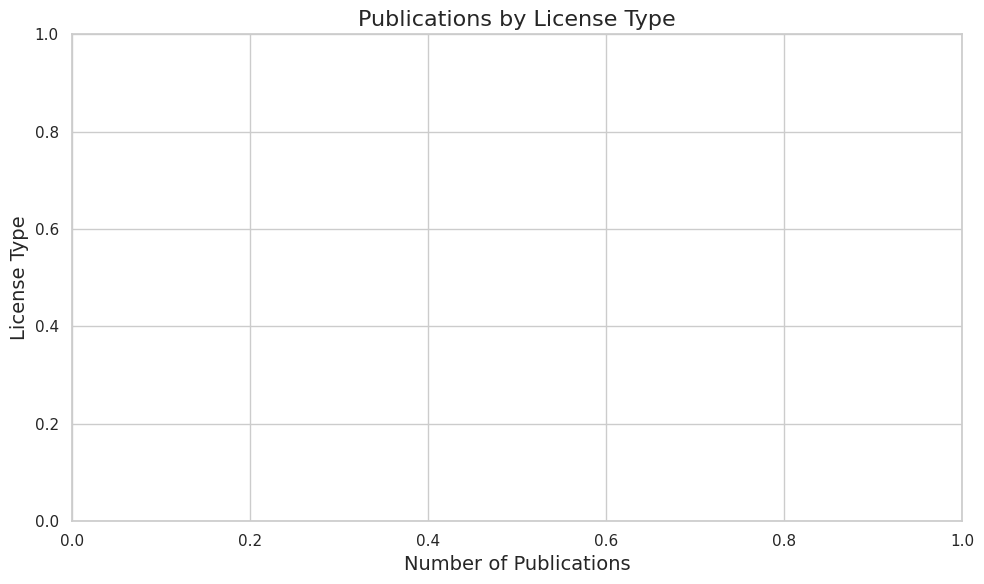

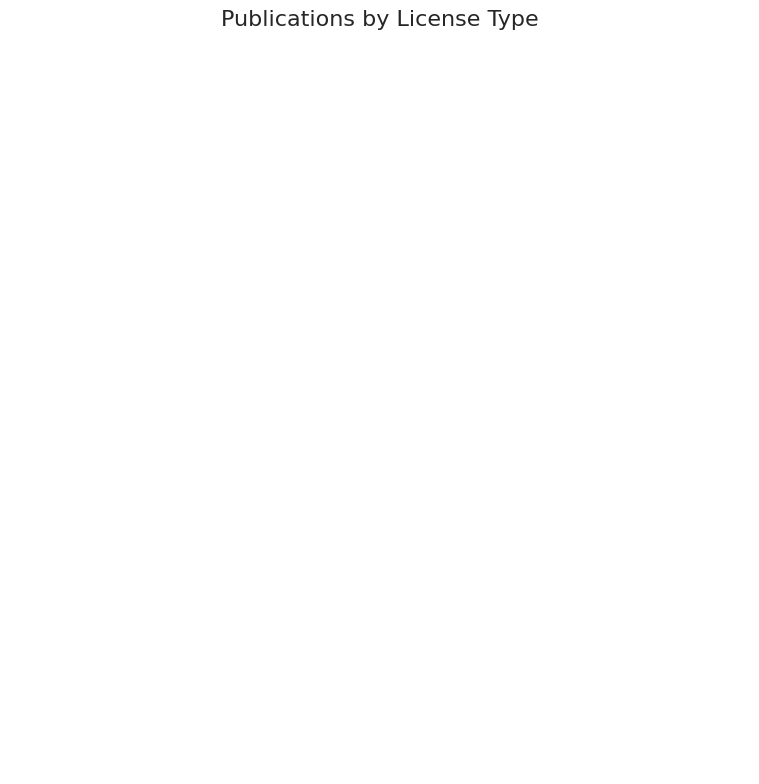

In [37]:
license_counts = merged_df['License Name'].dropna().astype(str).str.strip().value_counts()
plt.figure(figsize=(10, 6))
colors = sns.color_palette("colorblind")
ax = sns.barplot(y=license_counts.index, x=license_counts.values, palette=colors)
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('License Type', fontsize=14)
ax.set_title('Publications by License Type', fontsize=16)
for i, v in enumerate(license_counts.values):
    ax.text(v + max(license_counts.values)*0.01, i, f"{v}", va='center', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_license_type.png"), dpi=300)
plt.show()

# Optional: Pie chart
plt.figure(figsize=(8, 8))
plt.pie(license_counts.values, labels=license_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Publications by License Type', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_license_type_pie.png"), dpi=300)
plt.show()


/tmp/ipython-input-38-893971196.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(language_counts.keys()), y=list(language_counts.values()), palette="colorblind")


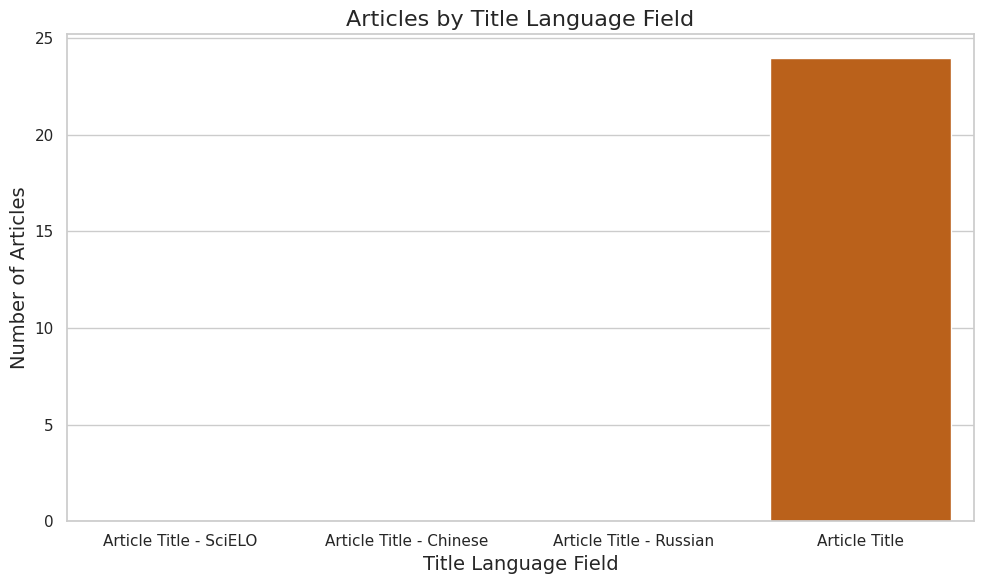

In [38]:
# Count non-null for each title language field
language_fields = ['Article Title - SciELO', 'Article Title - Chinese', 'Article Title - Russian', 'Article Title - Arabic', 'Article Title']
language_counts = {lang: merged_df[lang].dropna().shape[0] for lang in language_fields if lang in merged_df.columns}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(language_counts.keys()), y=list(language_counts.values()), palette="colorblind")
plt.xlabel('Title Language Field', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.title('Articles by Title Language Field', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "articles_by_title_language.png"), dpi=300)
plt.show()


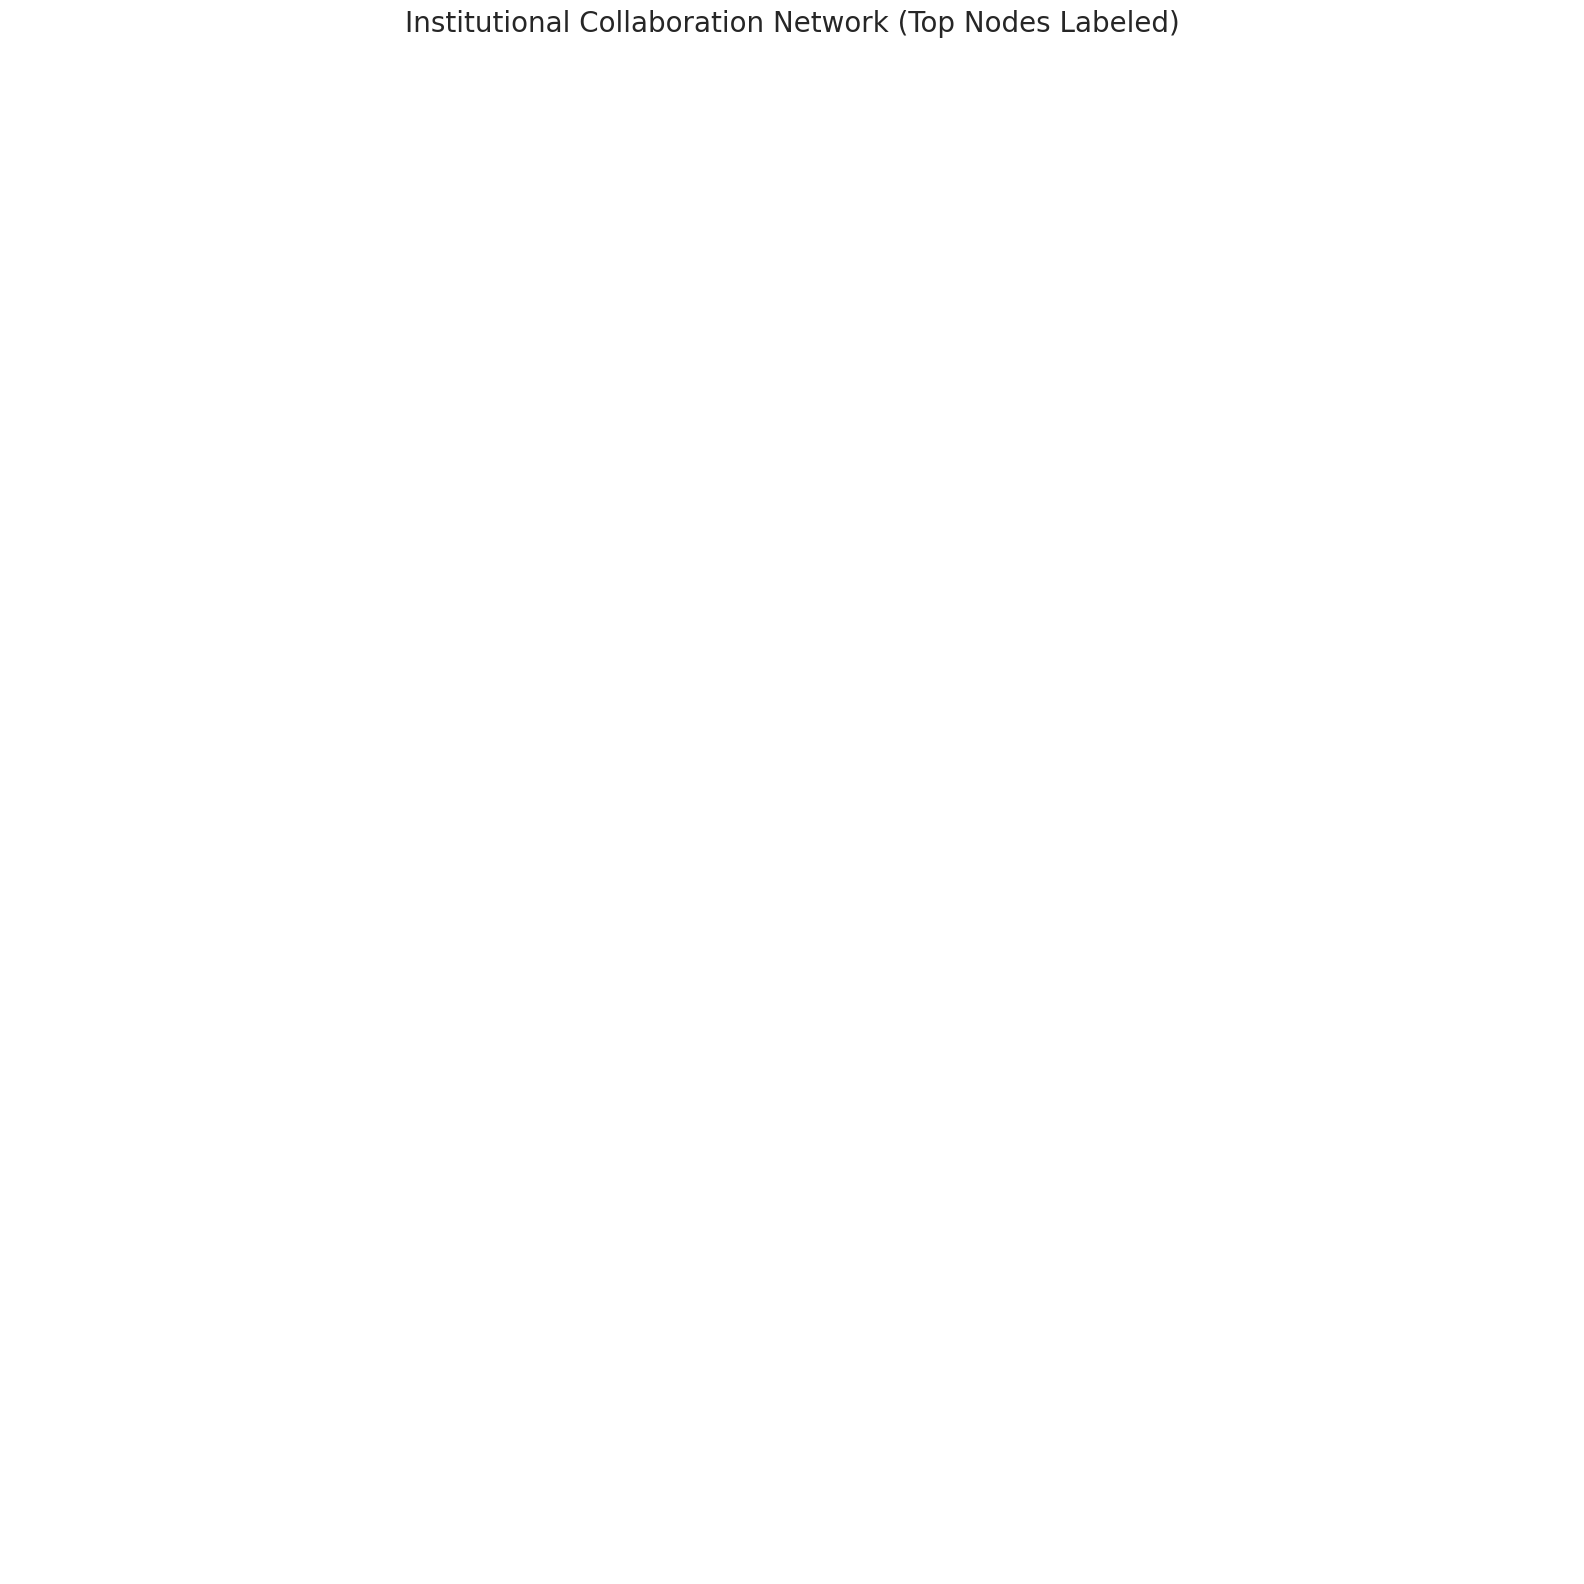

In [39]:
import networkx as nx
from collections import Counter

# Prepare data
institution_series = merged_df['Institution'].dropna().astype(str)
collaborations = []
for inst_list in institution_series:
    institutions = [inst.strip() for inst in inst_list.replace(';', ',').split(',') if inst.strip()]
    if len(institutions) > 1:
        for i in range(len(institutions)):
            for j in range(i + 1, len(institutions)):
                collaborations.append((institutions[i], institutions[j]))

# Build network
G = nx.Graph()
G.add_edges_from(collaborations)

# Node size proportional to total collaborations
inst_counts = Counter([inst for pair in collaborations for inst in pair])
node_sizes = [inst_counts.get(node, 1) * 30 for node in G.nodes()]

plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G, k=0.18, iterations=30, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#009E73', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)
# Label only the 25 most connected
top_nodes = dict(sorted(inst_counts.items(), key=lambda item: item[1], reverse=True)[:25])
nx.draw_networkx_labels(G, pos, {node: node for node in top_nodes}, font_size=11)
plt.title('Institutional Collaboration Network (Top Nodes Labeled)', fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "institutional_collaboration_network.png"), dpi=300)
plt.show()


In [40]:
# Prepare data
conference_series = merged_df['Conference Title'].dropna().astype(str)
conference_flat = [c.strip() for sublist in conference_series for c in sublist.replace(';', ',').split(',') if c.strip()]
conference_counts = Counter(conference_flat)
top_conferences = conference_counts.most_common(15)
confs, counts = zip(*top_conferences)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=list(confs), x=list(counts), palette="colorblind")
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Conference Event', fontsize=14)
ax.set_title('Distribution by Conference Event (Top 15)', fontsize=16)
for i, v in enumerate(counts):
    ax.text(v + max(counts)*0.01, i, f"{v}", va='center', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "conference_events_distribution.png"), dpi=300)
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)

In [41]:
subject_series = merged_df['Author Keywords'].dropna().astype(str)
subjects_flat = [s.strip().title() for sublist in subject_series for s in sublist.replace(';', ',').split(',') if s.strip()]
subject_counts = Counter(subjects_flat)
top_subjects = subject_counts.most_common(15)

if top_subjects:  # Só gera o gráfico se houver dados
    subjects, counts = zip(*top_subjects)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(y=list(subjects), x=list(counts), palette="colorblind")
    ax.set_xlabel('Number of Publications', fontsize=14)
    ax.set_ylabel('Thematic Area', fontsize=14)
    ax.set_title('Publications by Thematic Area (Top 15)', fontsize=16)
    for i, v in enumerate(counts):
        ax.text(v + max(counts)*0.01, i, f"{v}", va='center', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "publications_by_thematic_area.png"), dpi=300)
    plt.show()
else:
    print("No subjects found in the selected column.")


No subjects found in the selected column.


/tmp/ipython-input-42-1050266031.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=list(sponsors), x=list(counts), palette="colorblind")


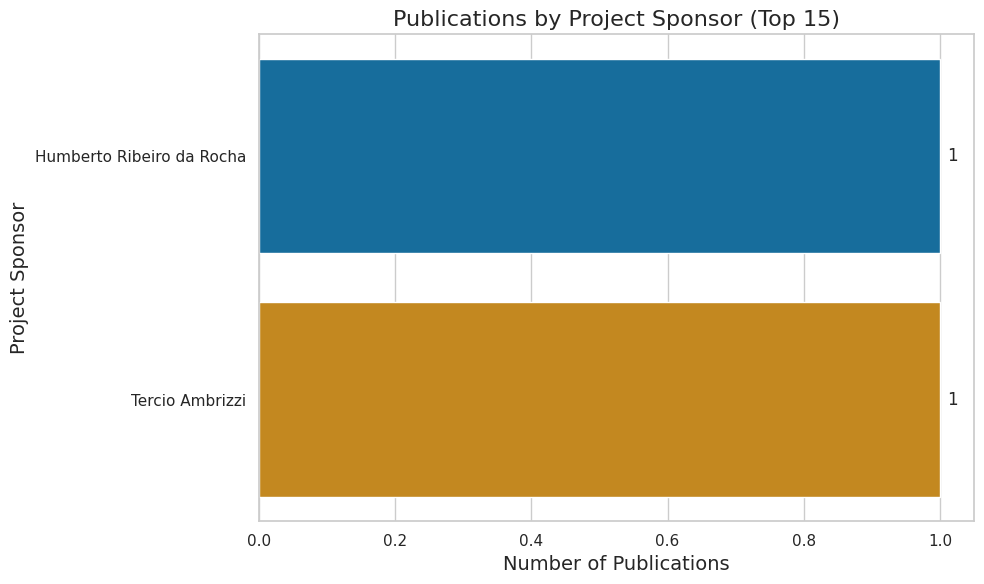

In [42]:
sponsor_series = merged_df['Grant Principal Investigator'].dropna().astype(str)
sponsor_flat = [s.strip() for sublist in sponsor_series for s in sublist.replace(';', ',').split(',') if s.strip()]
sponsor_counts = Counter(sponsor_flat)
top_sponsors = sponsor_counts.most_common(15)
sponsors, counts = zip(*top_sponsors)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=list(sponsors), x=list(counts), palette="colorblind")
ax.set_xlabel('Number of Publications', fontsize=14)
ax.set_ylabel('Project Sponsor', fontsize=14)
ax.set_title('Publications by Project Sponsor (Top 15)', fontsize=16)
for i, v in enumerate(counts):
    ax.text(v + max(counts)*0.01, i, f"{v}", va='center', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_project_sponsor.png"), dpi=300)
plt.show()


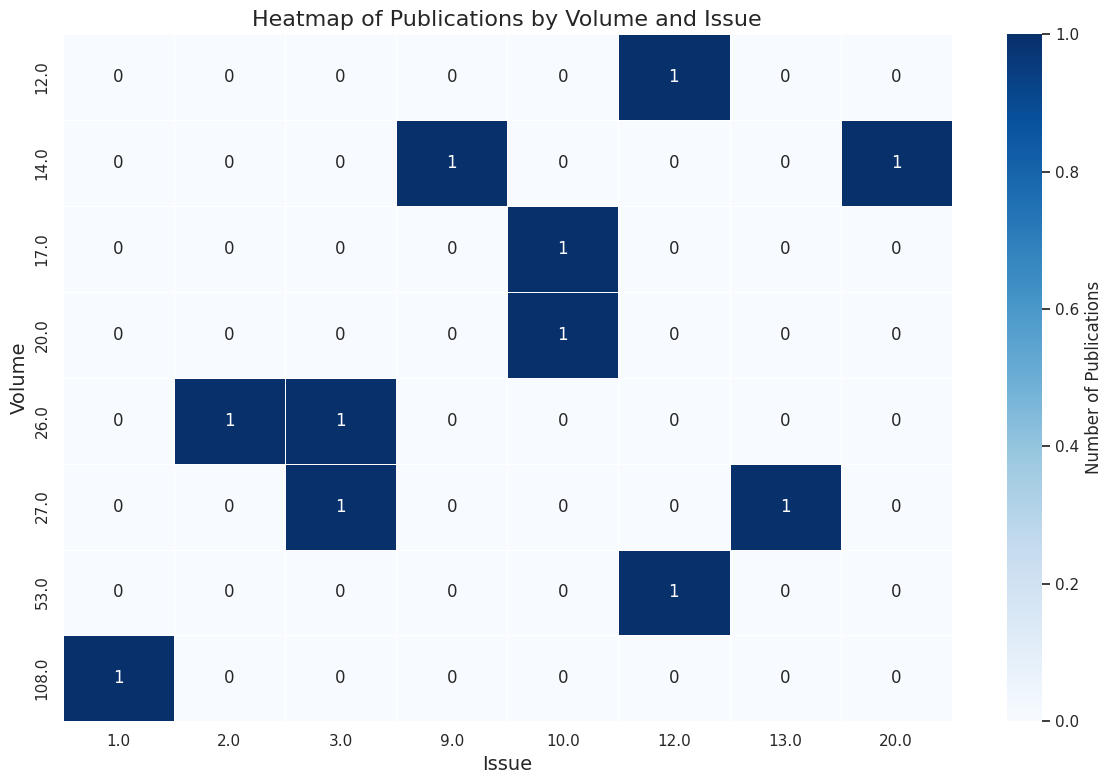

In [43]:
# Clean and convert volume/issue
merged_df['Volume'] = pd.to_numeric(merged_df['Volume'], errors='coerce')
merged_df['Issue'] = pd.to_numeric(merged_df['Issue'], errors='coerce')
heatmap_data = merged_df.groupby(['Volume', 'Issue']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Number of Publications'})
plt.xlabel('Issue', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.title('Heatmap of Publications by Volume and Issue', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "heatmap_volume_issue.png"), dpi=300)
plt.show()


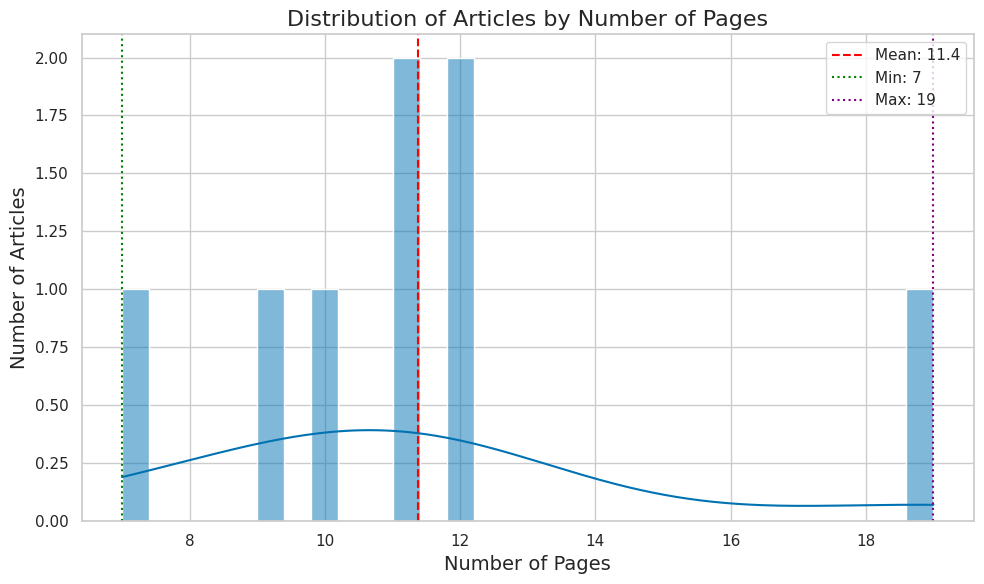

In [44]:
# Clean and compute number of pages
merged_df['Start Page'] = pd.to_numeric(merged_df['Start Page'], errors='coerce')
merged_df['End Page'] = pd.to_numeric(merged_df['End Page'], errors='coerce')
merged_df['Num Pages'] = merged_df['End Page'] - merged_df['Start Page'] + 1
valid_pages = merged_df['Num Pages'].dropna()
valid_pages = valid_pages[(valid_pages > 0) & (valid_pages < 200)]  # Remove likely outliers

mean_pages = valid_pages.mean()
min_pages = valid_pages.min()
max_pages = valid_pages.max()

plt.figure(figsize=(10, 6))
sns.histplot(valid_pages, bins=30, color='#0072B2', kde=True)
plt.xlabel('Number of Pages', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.title('Distribution of Articles by Number of Pages', fontsize=16)
plt.axvline(mean_pages, color='red', linestyle='--', label=f'Mean: {mean_pages:.1f}')
plt.axvline(min_pages, color='green', linestyle=':', label=f'Min: {min_pages:.0f}')
plt.axvline(max_pages, color='purple', linestyle=':', label=f'Max: {max_pages:.0f}')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "articles_by_number_of_pages.png"), dpi=300)
plt.show()


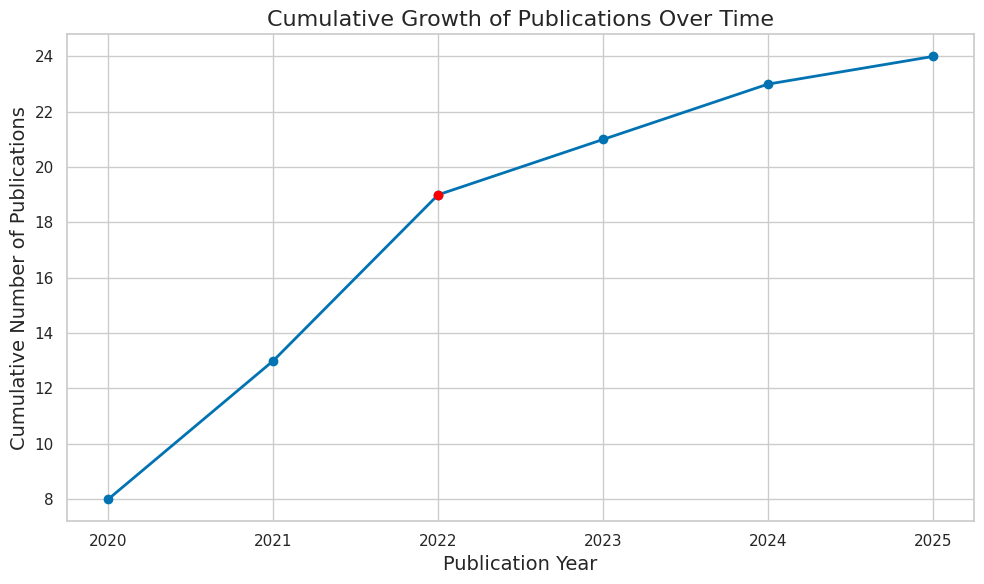

In [45]:
# Clean and prepare year data
merged_df['Publication Year'] = merged_df['Publication Year'].astype(str).str.extract(r'(\d{4})')[0]
merged_df = merged_df.dropna(subset=['Publication Year'])
merged_df['Publication Year'] = merged_df['Publication Year'].astype(int)
pubs_per_year = merged_df['Publication Year'].value_counts().sort_index()
cumulative = pubs_per_year.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative.index, cumulative.values, marker='o', linewidth=2)
plt.xlabel('Publication Year', fontsize=14)
plt.ylabel('Cumulative Number of Publications', fontsize=14)
plt.title('Cumulative Growth of Publications Over Time', fontsize=16)
# Highlight inflection points (change of growth rate)
from scipy.signal import find_peaks
peaks, _ = find_peaks(np.diff(cumulative.values), prominence=1)
for peak in peaks:
    plt.scatter(cumulative.index[peak+1], cumulative.values[peak+1], color='red', zorder=5)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "cumulative_publication_growth.png"), dpi=300)
plt.show()


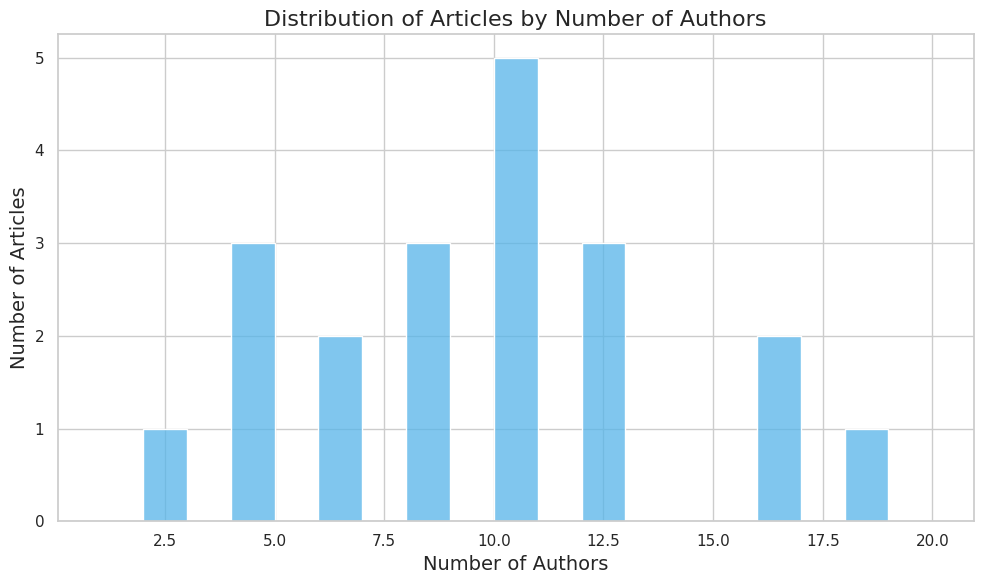

In [46]:
# Count number of authors per article
def count_authors(authors):
    if pd.isnull(authors):
        return 0
    return len([a.strip() for a in str(authors).replace(';', ',').split(',') if a.strip()])

merged_df['Num Authors'] = merged_df['Authors'].apply(count_authors)
valid_num_authors = merged_df['Num Authors'][merged_df['Num Authors'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(valid_num_authors, bins=range(1, 21), color='#56B4E9')
plt.xlabel('Number of Authors', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.title('Distribution of Articles by Number of Authors', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "articles_by_number_of_authors.png"), dpi=300)
plt.show()


In [47]:
from collections import Counter

patent_series = merged_df['Patent Number'].dropna().astype(str)

if not patent_series.empty:
    patent_types = [pat[:2] if len(pat) >= 2 else 'Other' for pat in patent_series]
    patent_type_counts = Counter(patent_types)
    top_patent_types = patent_type_counts.most_common(10)
    if top_patent_types:
        types, counts = zip(*top_patent_types)
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(y=list(types), x=list(counts), palette="colorblind")
        ax.set_xlabel('Number of Patents', fontsize=14)
        ax.set_ylabel('Patent Category (Prefix)', fontsize=14)
        ax.set_title('Publications by Patent Category (Top 10)', fontsize=16)
        for i, v in enumerate(counts):
            ax.text(v + max(counts)*0.01, i, f"{v}", va='center', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "publications_by_patent_category.png"), dpi=300)
        plt.show()
    else:
        print("No valid patent category data found after cleaning.")
else:
    print("No patent number data available in the dataset.")


No patent number data available in the dataset.


<Figure size 1200x600 with 0 Axes>

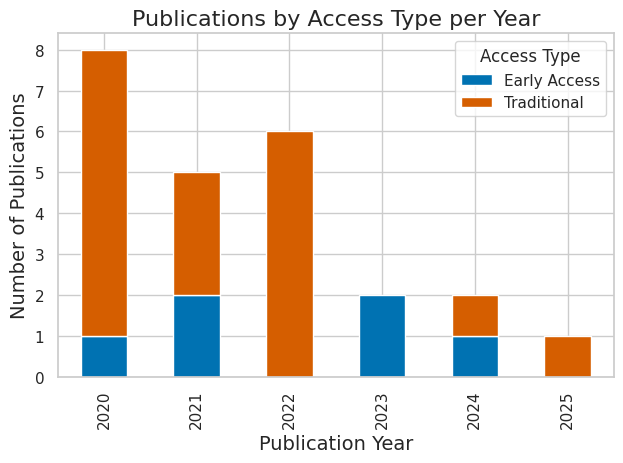

In [48]:
# Prepare data
early_access = merged_df['Early Access Date'].notnull()
merged_df['Access Type'] = early_access.replace({True: 'Early Access', False: 'Traditional'})
access_by_year = merged_df.groupby(['Publication Year', 'Access Type']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
access_by_year.plot(kind='bar', stacked=True, color=['#0072B2', '#D55E00'])
plt.xlabel('Publication Year', fontsize=14)
plt.ylabel('Number of Publications', fontsize=14)
plt.title('Publications by Access Type per Year', fontsize=16)
plt.legend(title='Access Type')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "publications_by_access_type.png"), dpi=300)
plt.show()


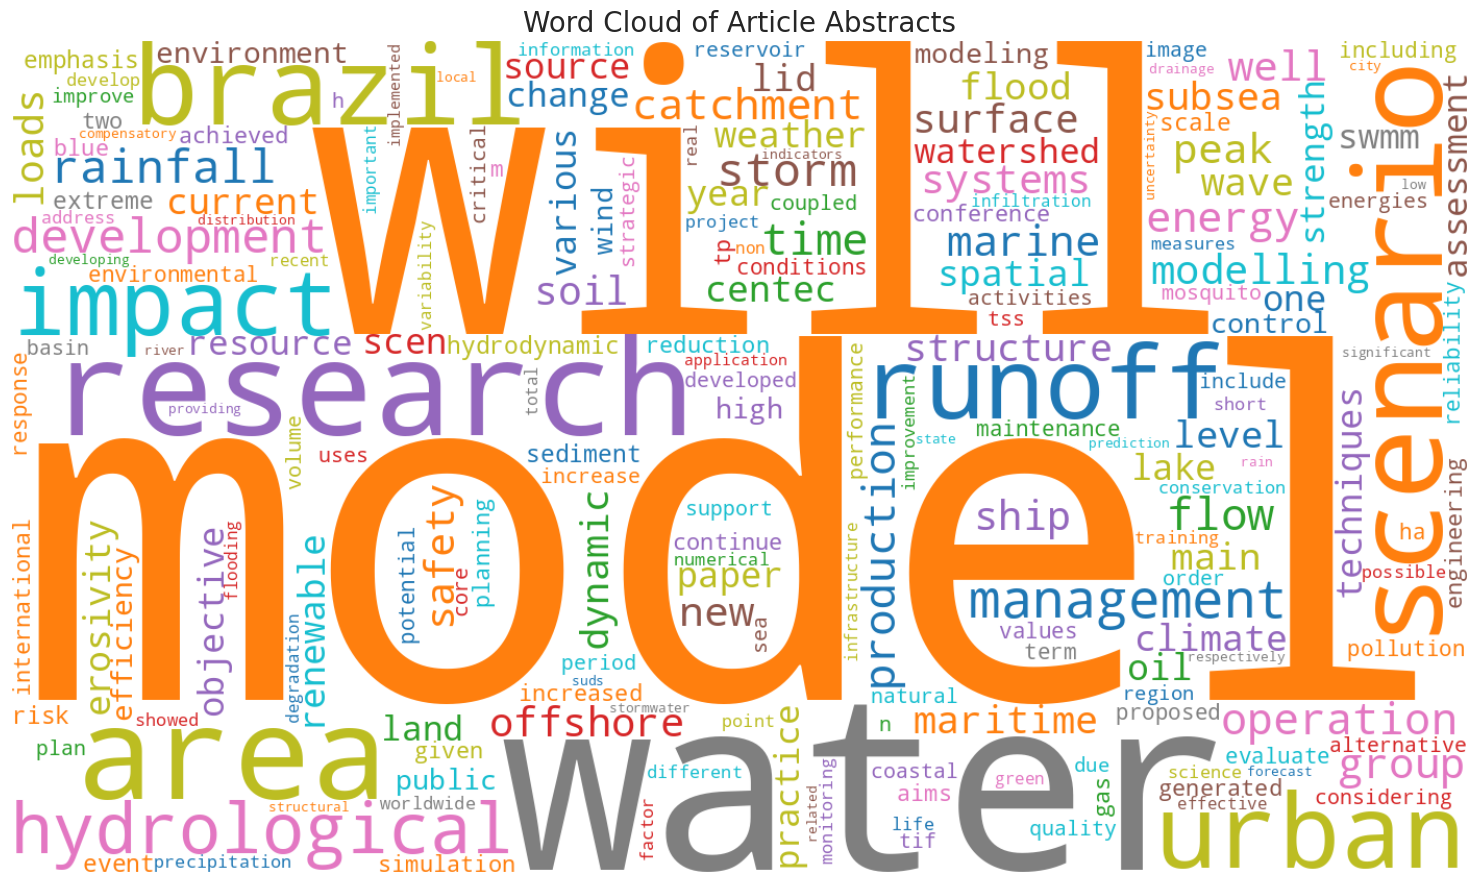

In [49]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all abstracts into one large string
abstract_series = merged_df['Abstract'].dropna().astype(str)
all_abstract_text = ' '.join(abstract_series).lower()

# Define stopwords (add domain-specific words if desired)
custom_stopwords = set(STOPWORDS).union({
    'study', 'analysis', 'effect', 'effects', 'data', 'system', 'method', 'methods',
    'result', 'results', 'use', 'used', 'using', 'based', 'approach', 'provide', 'within'
})

# Create the word cloud
wordcloud = WordCloud(
    width=1400,
    height=800,
    background_color='white',
    colormap='tab10',
    stopwords=custom_stopwords,
    max_words=200,
    collocations=False,
    normalize_plurals=True
).generate(all_abstract_text)

# Plot
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Article Abstracts', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "wordcloud_abstracts.png"), dpi=300)
plt.show()
